# MSE 446 Project
## car-price-prediction-ml
## Group Members: Kiyon Farokhi and Eunchan Koh

### Revised Problem Statement
Accurately determining a fair price for a car can be challenging for both individuals and dealerships. Consumers who lack in-depth pricing knowledge risk overpaying or falling victim to scams, while dealerships may inadvertently overvalue or undervalue their inventory. To address this issue, we propose developing a machine learning model that forecasts the fair market price of a car using comprehensive data from a wholesale car dealer website. This model will consider a wide range of factors—including brand, model, production year, mileage, accident history, and additional features—to generate reliable price estimates. Ultimately, the model’s predictions aim to help both consumers and dealerships make more informed decisions about buying or selling vehicles.

Machine learning offers a more robust and flexible approach to car price prediction because it can capture the complex interactions and non-linear relationships among a broad set of variables. Unlike traditional pricing models, which typically rely on a small number of features or strict linear assumptions, machine learning models adapt to market changes over time by integrating new data into their training process. This adaptability is especially important in a market subject to evolving consumer preferences, economic conditions, and seasonal trends. Furthermore, machine learning methods can incorporate a richer variety of inputs—including structured data like vehicle mileage and brand, as well as unstructured data such as text descriptions or vehicle history reports—leading to more accurate and insightful price forecasts. By continuously learning from new information and uncovering hidden patterns that conventional models might overlook, a machine learning–based pricing system can provide more reliable and up-to-date valuation guidance.
**Hypothesis:** Incorporating time-based features (e.g., incremental mileage, adjusted depreciation for future years) into a tree-based ensemble model (e.g., Random Forest) will reduce the Root Mean Squared Error (RMSE) of 1–3 year car resale price predictions by at least 20% compared to a baseline linear regression model.

### Revised Project Methodology 
1. **Data Collection & Cleaning**
    - We will acquire a dataset containing historical car sales and listings (e.g., from a public repository on Kaggle or an open-source dealership data API).
    - The dataset will include features such as:
        - *Categorical*: Model, Transmission, FuelType
        - *Numerical*: Year of Manufacture, Mileage, Road Tax, Miles Per Gallon, Engine Size, Sales Price
    - We will inspect the data for missing values, perform imputation where feasible, and remove unusable entries if necessary.
2. **Feature Engineering**
    - **One-Hot Encoding** for categorical features (e.g., Model_A1, Model_A6).
    - **Time-Based Variables**: Create a feature for “Car Age” at the time of sale, and incorporate projection for future years (e.g., Car Age + n).
    - **Interaction Terms**: Possibly derive advanced features such as (Brand × Accident History) if it appears relevant.
    - **Normalization** or **Standardization** of continuous features (Mileage, Engine Size) to aid certain algorithms.
3. **Model Selection & Modification**
    - **Baseline Model**: Multiple Linear Regression to provide a straightforward benchmark.
    - **Advanced Models**:
        - **Random Forest Regression** or **Gradient Boosting** (XGBoost) to capture nonlinear interactions.
        - (Optional) **Modification**: We may experiment with weighting recent data more heavily, or integrating external economic indicators (e.g., inflation rates, fuel costs) to enhance long-term predictive accuracy.
    - We will compare performance across these models to identify which approach best handles multi-year price forecasting.
4. **Validation & Evaluation**
    - **Train/Test Split**: We will split the dataset 80/20 (or similar).
    - **k-Fold Cross-Validation**: 5-fold or 10-fold CV to ensure robust performance estimates.
    - **Performance Metrics**:
        - *Mean Squared Error (MSE)* and *Root Mean Squared Error (RMSE)* for penalizing larger errors.
        - *Mean Absolute Error (MAE)* for straightforward interpretability (price in dollars).
        - *R² Score* for overall fit.
5. **Future Price Prediction**
    - **Long-Term Forecasting**: We will simulate future conditions by incrementing the car’s age/mileage to a target year (e.g., +1 year, +3 years).
    - **User-Adjustable Inputs**: For demonstration, we may build a simple interface (e.g., Streamlit or Jupyter notebook widgets) allowing the user to modify parameters like annual mileage growth or hypothetical “market shift” factors.
    - The model will then output an estimated **future** resale value, showing how different scenarios affect price predictions.
6. **Reporting & Insights**
    - We will document the entire pipeline: data preprocessing, model training, hyperparameter tuning, and model comparison results.
    - **Business/Scientific Insights**:
        - Identify top predictive features (e.g., using feature importances or SHAP).
        - Discuss how future vehicle demand, technology trends (EV vs. gas), or mileage constraints might shift predicted values.
    - Our final write-up will include **recommendations** on how these insights can inform pricing decisions for stakeholders (dealerships, private sellers, or fleet managers).

### Import Libraries

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')


### Implementing Multiple Linear Regression with audi.csv

In [14]:
# get new car dataset
df_new_cars = pd.read_csv('audi.csv')

# inspecting the data
display(df_new_cars.head())
display(df_new_cars.info())
display(df_new_cars.describe())


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,A1,2017,Manual,15735,Petrol,150,55.4,1.4,12500
1,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,16500
2,A1,2016,Manual,29946,Petrol,30,55.4,1.4,11000
3,A4,2017,Automatic,25952,Diesel,145,67.3,2.0,16800
4,A3,2019,Manual,1998,Petrol,145,49.6,1.0,17300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   mileage       10668 non-null  int64  
 4   fuelType      10668 non-null  object 
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


None

,year,mileage,tax,mpg,engineSize,price
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,24827.244001,126.011436,50.770022,1.930709,22896.685039
std,2.167494,23505.257205,67.170294,12.949782,0.602957,11714.841888
min,1997.000000,1.000000,0.000000,18.900000,0.000000,1490.000000
25%,2016.000000,5968.750000,125.000000,40.900000,1.500000,15130.750000
50%,2017.000000,19000.000000,145.000000,49.600000,2.000000,20200.000000
75%,2019.000000,36464.500000,145.000000,58.900000,2.000000,27990.000000
max,2020.000000,323000.000000,580.000000,188.300000,6.300000,145000.000000


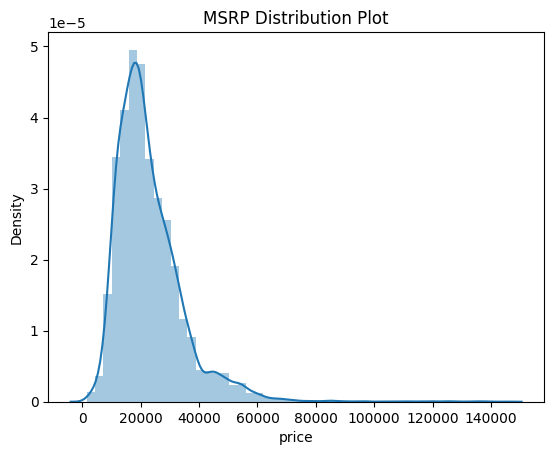

In [15]:
# Data Distribution
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
plt.title('MSRP Distribution Plot')
sns.distplot(df_new_cars['price'])
plt.show()

## Distribution Plot analysis
While testing different limits on x, it seems like the dataset has outlier cars. 

In [56]:
# creating price groups in 10 000 increments
# df_new_cars['price_group'] = pd.cut(df_new_cars['price'],
#                                     bins=range(0,600000 + 10000, 10000),
#                                     right=False)
# count number of vehicles per price group
# price_group_counts = df_new_cars['price_group'].value_counts().sort_index()
# print(df_new_cars['price_group'].isnull())



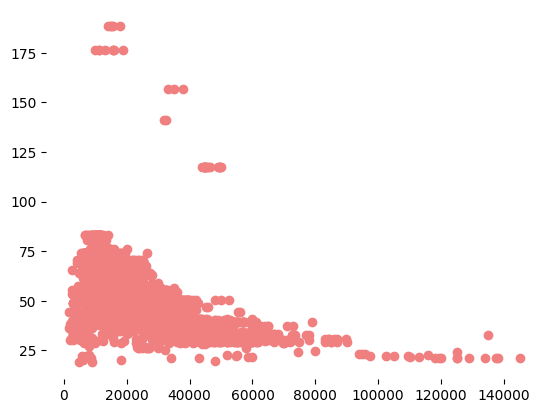

In [75]:
# Relationship between mpg and MSRP
plt.scatter(df_new_cars['price'], df_new_cars['mpg'], color='lightcoral')
plt.box(False)
plt.show()

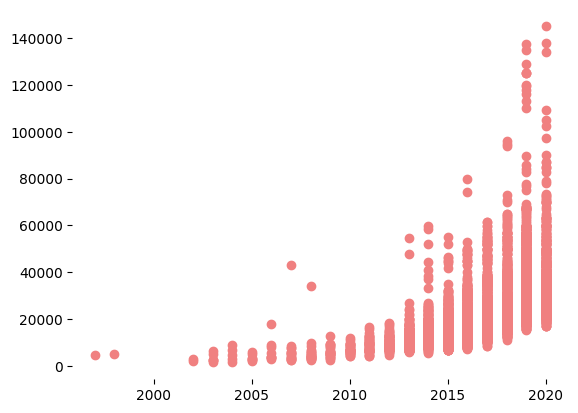

In [76]:
# Relationship between year and price
plt.scatter(df_new_cars['year'], df_new_cars['price'], color='lightcoral')
plt.box(False)
plt.show()

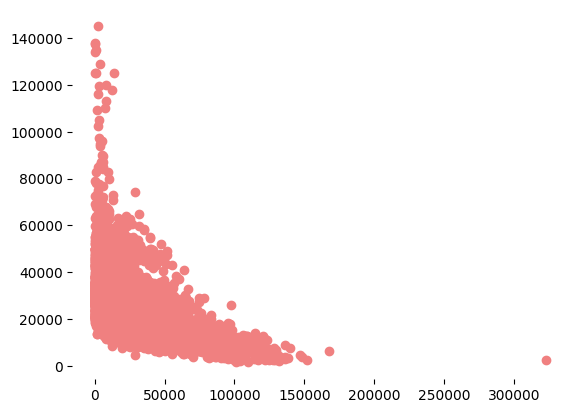

In [77]:
# Relationship between mileage and price
plt.scatter(df_new_cars['mileage'], df_new_cars['price'], color='lightcoral')
plt.box(False)
plt.show()

We expected the dataset to be linear and has homoscedasticity. However, it mostly has trait of heteroscedasticity.

In [20]:
# For creating One-Hot-encoding for categories and to scaling the values
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [0,1,2,3,4])
        # ('cat', categorical_transformer, [0,2,4])
    ], remainder='passthrough'
)

In [21]:
#function to erase white space if the input is string. Then returns the character without white spaces.
def strip_if_str(x):
    return x.strip() if isinstance(x,str) else x

In [22]:
# let X be the variables and Y be the price output. Then also adding columns for one-hot-encoding.
X = df_new_cars.iloc[:, :-1]
X = pd.get_dummies(X, columns=['model', 'transmission', 'fuelType'],dtype=int) 

#save the column names using this
column_names = X.columns.to_numpy()

# Since price is on the last column, we can get the price column by following
y = df_new_cars.iloc[:, -1].values
print(df_new_cars)

#some strings have white spaces. Erase the white spaces using following
X = np.vectorize(strip_if_str)(X)

#And using this, change the df so hot-encoding for categories and standard scaling is applied to X
X = ct.fit_transform(X)


      model  year transmission  mileage fuelType  tax   mpg  engineSize  price
0        A1  2017       Manual    15735   Petrol  150  55.4         1.4  12500
1        A6  2016    Automatic    36203   Diesel   20  64.2         2.0  16500
2        A1  2016       Manual    29946   Petrol   30  55.4         1.4  11000
3        A4  2017    Automatic    25952   Diesel  145  67.3         2.0  16800
4        A3  2019       Manual     1998   Petrol  145  49.6         1.0  17300
...     ...   ...          ...      ...      ...  ...   ...         ...    ...
10663    A3  2020       Manual     4018   Petrol  145  49.6         1.0  16999
10664    A3  2020       Manual     1978   Petrol  150  49.6         1.0  16999
10665    A3  2020       Manual      609   Petrol  150  49.6         1.0  17199
10666    Q3  2017    Automatic     8646   Petrol  150  47.9         1.4  19499
10667    Q3  2016       Manual    11855   Petrol  150  47.9         1.4  15999

[10668 rows x 9 columns]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

np.set_printoptions(precision = 2)
result = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1)

#so we got this result. Left values are the predicted values, and the values on the right are the actual values on test data.
print(result)

[[12732.11 14998.  ]
 [27554.99 21950.  ]
 [30460.11 28990.  ]
 ...
 [49080.49 45995.  ]
 [30319.02 30500.  ]
 [ 7317.01  8400.  ]]


In [24]:
#as the output, we got the coefficients and intercept values as following
temp1 = regressor.coef_

temp = np.vstack((column_names, temp1))
print(temp)
# print(f'Coefficient: {regressor.coef_}')

print(f'Intercept: {regressor.intercept_}')

[['year' 'mileage' 'tax' 'mpg' 'engineSize' 'model_ A1' 'model_ A2'
  'model_ A3' 'model_ A4' 'model_ A5' 'model_ A6' 'model_ A7' 'model_ A8'
  'model_ Q2' 'model_ Q3' 'model_ Q5' 'model_ Q7' 'model_ Q8' 'model_ R8'
  'model_ RS3' 'model_ RS4' 'model_ RS5' 'model_ RS6' 'model_ RS7'
  'model_ S3' 'model_ S4' 'model_ S5' 'model_ S8' 'model_ SQ5'
  'model_ SQ7' 'model_ TT' 'transmission_Automatic' 'transmission_Manual'
  'transmission_Semi-Auto' 'fuelType_Diesel' 'fuelType_Hybrid'
  'fuelType_Petrol']
 [3956.066049304593 -1847.6252154414738 -2000.8999025706273
  -3755.7145744553445 2769.969258260571 -11812.865164279001
  7387.65623318811 -10466.259257620866 -10156.039794507007
  -8825.683953318574 -8145.106332557499 -7403.570909343718
  -3757.3301447343715 -10249.639821122228 -8845.182955566173
  -4948.312184156535 3348.6962480153793 13745.02478657857
  49677.17528014478 -2036.252199089776 8475.929648769106
  7848.3049522528545 15931.706983865775 7274.391801870968
  -6293.867031085512 483

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
result = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1)
sumUp = 0
for i in range(result.shape[0]):
    calValue = result[i][0] - result[i][1]
    calValue *= calValue
    sumUp += calValue
    
sumUp /= result.shape[0]
sumUp = math.sqrt(sumUp)

print("baseline's RMSE is:", sumUp)

baseline's RMSE is: 4033.452464246587


In [70]:
# same as the work above, but to make sure this function is also reliable
rmse = root_mean_squared_error(y_test, y_pred) # RMSE
print("RMSE of baseline is: ", rmse)

RMSE of baseline is:  4033.452464246588


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# this function will be creating 100 decision trees. Each tree does not have limit on the depth, and each leaf can be having at least only one sample.
# All trees consider all features at most. It uses bootstrapping for creating the trees, and it does not have any seed number for randomness.
# However, if the random seed number need to be used, include random_state=0 or 42.
# By default, Each tree has same number of the sample as the size of randomly selected 80% training data at most.
# To modify, we can change the maximum number of samples in each tree using max_sample=n.
# currently, using the sample size equal to 80% of the training dataset.
sampleSize = int(X_train.shape[0]*0.8)
print("Sample Size is: ", sampleSize)
rf = RandomForestRegressor(n_estimators=100, max_samples=sampleSize)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred) # RMSE
print("RMSE of random forest regression is: ", rmse)

Sample Size is:  6827
RMSE of random forest regression is:  2170.671538701629


In [72]:
# for k-fold testing, k=5 since our training dataset has 80% of entire dataset
# Since the dataset is not organized(such as time-based), set shuffle to true.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_result = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_result += rmse

rmse_result /= 5

print("Average RMSE:", rmse_scores)

Average RMSE: 2346.5504303033317


## Results
The solution of having Random Forest Regression using the variables we got from data and one-hot-encoding had much smaller value of RMSE compared to when we used the multiple linear regression method. 

Our initial purpose is to create the ideal model to predict price of cars. The reason why we picked the multiple linear regression as the method to create a price predicting model is because we expected the practical data of car sales to be linear since lots of data values were numeric. We expected that it would be a perfect method to have since multiple linear regression takes much less time for calculation compared to other methods. However, the actual dataset we got from our resources had a trend of heteroscedasticity instead of homoscedasticity, making it unable to create a linear regression model with least RMSE since data are spreading as variable values increase/decrease. Therefore to create a better price prediction model, we had to choose a different method. The model we picked was the Random Forest Regression, and it worked much better compared to the multiple linear regression. 

However, Random Forest Regression model also had a weak points as well, which is it takes much longer time and much more resources to calculate and predict the price. It will be taking longer time and more resources as the size of the dataset increases. One of the method to treat this problem is to control how many trees we will be making based on how many feature and samples from the dataset, but this can be lowering the accuracy of the model, so we need to consider how much loss of accuracy we can tolerate, based on the purpose of the model.

By going through this project, we were able to learn about the traits and practical problems that we can face during creating the proper machine learning model for the dataset. Also, we learned the strength and weak points of both multiple linear regression and random forest regression model and how they works with actual dataset.


As the result shown, the RMSE of the result we gained from random forest regression is 30~46% less than the RMSE we gained using the linear regression model since the data had heteroscedasticity instead of homoscedasticity.

## Conclusion

As our hypothesis, the RMSE has decreased at least by 20% when we used the Random Forest Regression compared to the multiple linear regression. We thought that in car price prediction, linear regression model would be able to predict the price quickly with small RMSE. However, the practical dataset did not always have such an ideal trend, making it unable to predict car price precisely using multiple linear regression. We were able to realize the need of stronger price predicting model, how random forest regression works and the strength and weak points of it as well. If we were to continue this project, we would like to search up more about possible models we can have for price prediction and try to make better machine learning model for predicting more precise car price.